In [5]:
x = [0,1,1,1,1,0]
y = [0,2,3,4,5,0]
# pearson's correlation coefficient
import numpy as np
np.corrcoef(x,y)[0,1]

0.8749999999999998

In [1]:
# Here we want to load all the chiasm scores, find Pearson's correlation between them and then plot in the order of the greatest correlation
# starting with highest correlation to the originals (for old hebrew, old greek, and new greek). We'll make 3 figures. 
import os
import numpy as np
import json
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr
import glob
import pandas as pd

def load(file):
    with gzip.open(file, "rb") as ifd:
            data = [json.loads(line) for line in ifd]
    return data

In [4]:
# make a script that can load the embedding files, and the translation files at the same time.

# get the groupby.reshape(1,-1) object for each one (that’s basically the 1d list of position and chiasm strength

# put that into an array (rows are translation, columns are starting position(i))

# given an original file (maybe make the filename a column value), calculate the pearson’s corref

# sort the dataframe by that. Save that, 

# imshow the show thing, maybe. that makes it easier to plot probably.

# find the columns where the (std) is highest and lowest? Then look those up in the translation dataframe to print out those texts.

# it will be given a list of score files, and a list of translation files.
def create_array(score_files, threshold=0.05):
    data = {}
    for score_file in score_files:
        scores = load(score_file)
        df = pd.DataFrame.from_records(scores)
        df["color"] = df["p"].apply(lambda x: 1 if x < threshold else 0)
        df["color"] *= df["n"]
        # group by i and keep the n with the smallest p-value
        df = df.groupby("i").apply(lambda x: x.loc[x["p"].idxmin()]).reset_index(drop=True)
        data[score_file] = df['color'].values.reshape(1,-1)[0]
    return data


# make a dataframe from the data


In [5]:
wlc_score_files = ['/Users/hope/Documents/10 Projects/14 PhD/14.01 GitHub/literary-translation/chiasm_score_new_alg/work_old_WLC-Hebrew_original_Hebrew-chiasm.json.gz']

In [6]:
wlc_data = create_array(wlc_score_files, threshold=0.01)
# old_sinai_data = create_array(old_sinai_score_files, threshold=0.01)
# new_sinai_data = create_array(new_sinai_score_files, threshold=0.01)
# bc_data = create_array(bc_score_files, threshold=0.05)

In [7]:
wlc_df = pd.DataFrame({'file': wlc_data.keys(), 'chiasm_size': wlc_data.values()})
wlc_df['file'] = wlc_df['file'].apply(lambda x: os.path.basename(x).split('.')[0])
wlc_df.head()

,file,chiasm_size
0,work_old_WLC-Hebrew_original_Hebrew-chiasm,"[0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 9, 7, 0, 0, ..."


In [195]:
# repeat for the other data sets
old_sinai_df = pd.DataFrame({'file': old_sinai_data.keys(), 'chiasm_size': old_sinai_data.values()})
old_sinai_df['file'] = old_sinai_df['file'].apply(lambda x: os.path.basename(x).split('.')[0])
new_sinai_df = pd.DataFrame({'file': new_sinai_data.keys(), 'chiasm_size': new_sinai_data.values()})
new_sinai_df['file'] = new_sinai_df['file'].apply(lambda x: os.path.basename(x).split('.')[0])
bc_df = pd.DataFrame({'file': bc_data.keys(), 'chiasm_size': bc_data.values()})
bc_df['file'] = bc_df['file'].apply(lambda x: os.path.basename(x).split('.')[0])


In [8]:
def sort_df(df):
    # chiasm_size is a list
    df['binary'] = df['chiasm_size'].apply(lambda x: np.where(x > 0, 1, 0))
    original = df[df['file'].str.contains('original')]['chiasm_size'].values[0]
    print(original)
    df['pearson'] = df.apply(lambda x: pearsonr(original, x['chiasm_size'])[0], axis=1)
    df = df.sort_values('pearson', ascending=False)
    return df

wlc_df_sorted = sort_df(wlc_df)
wlc_df_sorted.head()

# repeat

[0 0 0 ... 0 0 0]


,file,chiasm_size,binary,pearson
0,work_old_WLC-Hebrew_original_Hebrew-chiasm,"[0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 9, 7, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...",1.0


In [197]:
# repeat
old_sinai_df_sorted = sort_df(old_sinai_df)
new_sinai_df_sorted = sort_df(new_sinai_df)
# bc_df_sorted = sort_df(bc_df)


[ 0 20 20 ...  0  0  0]
[10  7  6 ...  0  0  0]


In [9]:
# find extremems but works on a numpy array
def find_extremes(arr, n=5):
    std = np.std(arr, axis=0)
    # low means the chiasms that are the most consistent
    # std is low if the chiasm is consistent, and argsort will put things in order from low to high
    similar = np.argsort(std)[:n]
    # want to exclude ones where all values are 0
    # similar = similar[std[similar] > 0][:n]
    # we reverse it to get the highest values, as in the least consistent chiasms
    dissimilar = np.argsort(std)[::-1][:n]
    # high means the chiasms that are the least consistent
    return similar, dissimilar

# def find_extremes(df, n=5):
#     df['std'] = df['chiasm_size'].apply(lambda x: np.std(x))
#     df_high = df.sort_values('std', ascending=False)
#     df_low = df.sort_values('std', ascending=True)
#     return df_high.head(n), df_low.head(n)

# first we need to take the chiasm_size column and make that into a 2d array
wlc_array = np.array(wlc_df_sorted['chiasm_size'].values.tolist())
# wlc_chiasm = pd.DataFrame(wlc_array, columns=range(wlc_array.shape[1]))
# wlc_chiasm.head()
low, high = find_extremes(wlc_array)
low, high



(array([    0, 14119, 14118, 14117, 14116]),
 array([21174,  7051,  7053,  7054,  7055]))

In [12]:
wlc_df_sorted.head()

,file,chiasm_size,binary,pearson
0,work_old_WLC-Hebrew_original_Hebrew-chiasm,"[0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 9, 7, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...",1.0


In [11]:
wlc_array_binary = np.array(wlc_df_sorted['binary'].values.tolist())

# wlc_high = wlc_array_binary[]
# wlc_low, wlc_high = find_extremes(wlc_array_binary, n=10)

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [200]:
# repeat
old_sinai_array = np.array(old_sinai_df_sorted['chiasm_size'].values.tolist())
old_sinai_array_binary = np.array(old_sinai_df_sorted['binary'].values.tolist())
os_low, os_high = find_extremes(old_sinai_array_binary, n=10)

new_sinai_array = np.array(new_sinai_df_sorted['chiasm_size'].values.tolist())
new_sinai_array_binary = np.array(new_sinai_df_sorted['binary'].values.tolist())
ns_low, ns_high = find_extremes(new_sinai_array_binary, n=10)

# bc_array = np.array(bc_df_sorted['chiasm_size'].values.tolist())


In [154]:
translations

{'work_old_Sinaiticus-Greek_exclude_human_Finnish': Bible(/Users/hope/Documents/10 Projects/14 PhD/14.01 GitHub/literary-translation/translations/work_old_Sinaiticus-Greek_exclude_human_Finnish.json.gz),
 'work_old_Sinaiticus-Greek_exclude_both_Japanese': Bible(/Users/hope/Documents/10 Projects/14 PhD/14.01 GitHub/literary-translation/translations/work_old_Sinaiticus-Greek_exclude_both_Japanese.json.gz),
 'work_old_Sinaiticus-Greek_exclude_both_Turkish': Bible(/Users/hope/Documents/10 Projects/14 PhD/14.01 GitHub/literary-translation/translations/work_old_Sinaiticus-Greek_exclude_both_Turkish.json.gz),
 'work_old_Sinaiticus-Greek_exclude_human_Marathi': Bible(/Users/hope/Documents/10 Projects/14 PhD/14.01 GitHub/literary-translation/translations/work_old_Sinaiticus-Greek_exclude_human_Marathi.json.gz),
 'work_old_Sinaiticus-Greek_original_Greek': Bible(/Users/hope/Documents/10 Projects/14 PhD/14.01 GitHub/literary-translation/translations/work_old_Sinaiticus-Greek_original_Greek.json.g

In [14]:
! pip install pytextable

  Using cached pytextable-0.2.1-py3-none-any.whl (18 kB)


In [15]:
# for each i in low, find the corresponding text in the translation file. We can make it a table with the translation name, text, the chiasm length, and the score
import pytextable as pytex

wlc_translations = ['/Users/hope/Documents/10 Projects/14 PhD/14.01 GitHub/literary-translation/translations/work_old_WLC-Hebrew_original_Hebrew.json.gz','/Users/hope/Documents/10 Projects/14 PhD/14.01 GitHub/literary-translation/translations/work_old_BC_human_translation_English.json.gz']
def get_passages_for_inspection(high, array, df_sorted, trs, name):
    for num,i in enumerate(high):
        table_data = []
        print(i)
        sizes = array[:,i]
        print(sizes)
        # j is the index of the file, k is the chiasm size
        for j,k in enumerate(sizes):
            # print(j, k)
            file_name = df_sorted['file'].iloc[j]
            
            print(df_sorted['file'].iloc[j])
            print(trs[file_name.split('-chiasm')[0]].data[:5])
            print(trs[file_name.split('-chiasm')[0]].get_passage(start=i, end=i+k, sep='.'))
            
            table_data.append([file_name.replace('_', ' '), 
                                trs[file_name.split('-chiasm')[0]].data[i]['location'], \
                                k,
                                trs[file_name.split('-chiasm')[0]].get_passage(start=i, end=i+k, sep=' ')],)
        
    
        # make a dataframe and save to markdown (html)
        df = pd.DataFrame(table_data, columns=['File', 'Loc', 'Chiasm Size', 'Text'])
        df.to_csv(f'{name}_all_{num}.csv', index=False)
get_passages_for_inspection(wlc_array_binary, wlc_array, wlc_df_sorted, wlc_translations, 'wlc')
# get_passages_for_inspection(os_high, old_sinai_array, old_sinai_df_sorted, os_translations, 'old_sinai')
# get_passages_for_inspection(ns_high, new_sinai_array, new_sinai_df_sorted, ns_translations, 'new_sinai')
    # table = pytex.write(table_data, f'wlc_high_{num}.tex', header = ('File', 'Loc', 'Chiasm Size', 'Text', 'Score'))

    

[0 0 0 ... 0 0 0]
[[0 0 0 ... 0 0 0]]
work_old_WLC-Hebrew_original_Hebrew-chiasm


TypeError: list indices must be integers or slices, not str

In [92]:
wlc_array[:,4831]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 20, 12, 20, 20, 20,  0, 20,
       12, 12, 12, 12,  0,  0, 20, 20])

In [201]:

# let's load the translation files into Bible objects
# append path with ../scripts/utils.py
import sys
sys.path.append('../scripts')
from utils import Bible

# load the translation files
os_translations = {}
for file in old_sinai_translation_files:
    os_translation = Bible(file)
    os_translations[os.path.basename(file).split('.')[0]] = os_translation

ns_translations = {}
for file in new_sinai_translation_files:
    ns_translation = Bible(file)
    ns_translations[os.path.basename(file).split('.')[0]] = ns_translation

wlc_translations = {}
for file in wlc_translation_files:
    wlc_translation = Bible(file)
    wlc_translations[os.path.basename(file).split('.')[0]] = wlc_translation


In [174]:
from utils import Location
wlc_translations['work_old_WLC-Hebrew_unconstrained_English'][Location({"book": "GEN", "chapter": 1, "verse": 1})]

'In the beginning God created the heavens and the earth.'

In [1]:
# I have a csv where the columns are location, lengths_1, lengths_2, lengths_3, lengths_4, lengths_5
# i want to load it and then make it an array of 
import pandas as pd
import sys
sys.path.append('../data')
old_BC_SG_df = pd.read_csv('../data/old_BC_SG_df.csv')
# fill NA with 0
old_BC_SG_df = old_BC_SG_df.fillna(0)
old_BC_SG_df.head()
# we actually want each column in this to be a row in the array
old_BC_SG_array = old_BC_SG_df.values.T
columns = old_BC_SG_df.columns.values.tolist()
columns[:5]

['locations',
 'work_old_Sinaiticus-Greek_exclude_both_Turkish-chiasm.json.gz',
 'work_old_Sinaiticus-Greek_exclude_references_Finnish-chiasm.json.gz',
 'work_old_Sinaiticus-Greek_original_Greek-chiasm.json.gz',
 'work_old_Sinaiticus-Greek_unconstrained_Turkish-chiasm.json.gz']

In [2]:
locations = old_BC_SG_df['locations'].tolist()

In [3]:
old_BC_SG_df_shifted = pd.DataFrame(old_BC_SG_array[1:])
old_BC_SG_df_shifted.index = columns[1:]
old_BC_SG_df_shifted.head()


,0,1,2,3,4,5,6,7,8,9,...,24511,24512,24513,24514,24515,24516,24517,24518,24519,24520
work_old_Sinaiticus-Greek_exclude_both_Turkish-chiasm.json.gz,16,16,13,6,4,5,19,17,15,13,...,0,0,0,0,0,0,0,0,0,0
work_old_Sinaiticus-Greek_exclude_references_Finnish-chiasm.json.gz,19,20,8,14,4,20,19,17,19,13,...,0,0,0,0,0,0,0,0,0,0
work_old_Sinaiticus-Greek_original_Greek-chiasm.json.gz,13,20,16,19,17,15,16,20,20,16,...,0,0,0,0,0,0,0,0,0,0
work_old_Sinaiticus-Greek_unconstrained_Turkish-chiasm.json.gz,13,18,18,16,7,5,18,17,15,13,...,0,0,0,0,0,0,0,0,0,0
work_old_Sinaiticus-Greek_exclude_references_Marathi-chiasm.json.gz,8,20,17,6,4,20,19,17,15,13,...,0,0,0,0,0,0,0,0,0,0


'locations'

In [4]:
from scipy.stats.stats import pearsonr
#
#  find the row where "original" is in the index
original = old_BC_SG_df_shifted[old_BC_SG_df_shifted.index.str.contains('original')].values[0]
original

old_BC_SG_df_shifted['corr'] = old_BC_SG_df_shifted.apply(lambda x: pearsonr(original, x)[0], axis=1)
# sort by the correlation
old_BC_SG_df_shifted = old_BC_SG_df_shifted.sort_values('corr', ascending=False)
old_BC_SG_df_shifted

,0,1,2,3,4,5,6,7,8,9,...,24512,24513,24514,24515,24516,24517,24518,24519,24520,corr
work_old_Sinaiticus-Greek_original_Greek-chiasm.json.gz,13,20,16,19,17,15,16,20,20,16,...,0,0,0,0,0,0,0,0,0,1.000000
work_old_Sinaiticus-Greek_exclude_references_English-chiasm.json.gz,18,20,18,6,4,20,19,17,15,13,...,0,0,0,0,0,0,0,0,0,0.570366
work_old_Sinaiticus-Greek_unconstrained_English-chiasm.json.gz,14,20,18,6,4,20,19,17,15,13,...,0,0,0,0,0,0,0,0,0,0.568950
work_old_Sinaiticus-Greek_exclude_human_English-chiasm.json.gz,0,15,13,11,9,7,19,17,19,17,...,0,0,0,0,0,0,0,0,0,0.517371
work_old_Sinaiticus-Greek_exclude_both_English-chiasm.json.gz,0,15,13,11,9,7,19,17,19,17,...,0,0,0,0,0,0,0,0,0,0.514125
work_old_Sinaiticus-Greek_exclude_references_Swedish-chiasm.json.gz,18,18,18,11,9,20,19,17,19,13,...,0,0,0,0,0,0,0,0,0,0.491460
work_old_Sinaiticus-Greek_exclude_both_Finnish-chiasm.json.gz,19,15,13,11,9,7,19,17,15,13,...,0,0,0,0,0,0,0,0,0,0.491202
work_old_Sinaiticus-Greek_exclude_human_Finnish-chiasm.json.gz,19,15,13,11,9,7,19,17,15,13,...,0,0,0,0,0,0,0,0,0,0.491193
work_old_Sinaiticus-Greek_unconstrained_Swedish-chiasm.json.gz,18,15,18,11,9,20,19,17,15,13,...,0,0,0,0,0,0,0,0,0,0.488722
work_old_Sinaiticus-Greek_unconstrained_Finnish-chiasm.json.gz,19,20,8,14,4,20,19,17,19,13,...,0,0,0,0,0,0,0,0,0,0.483319


18


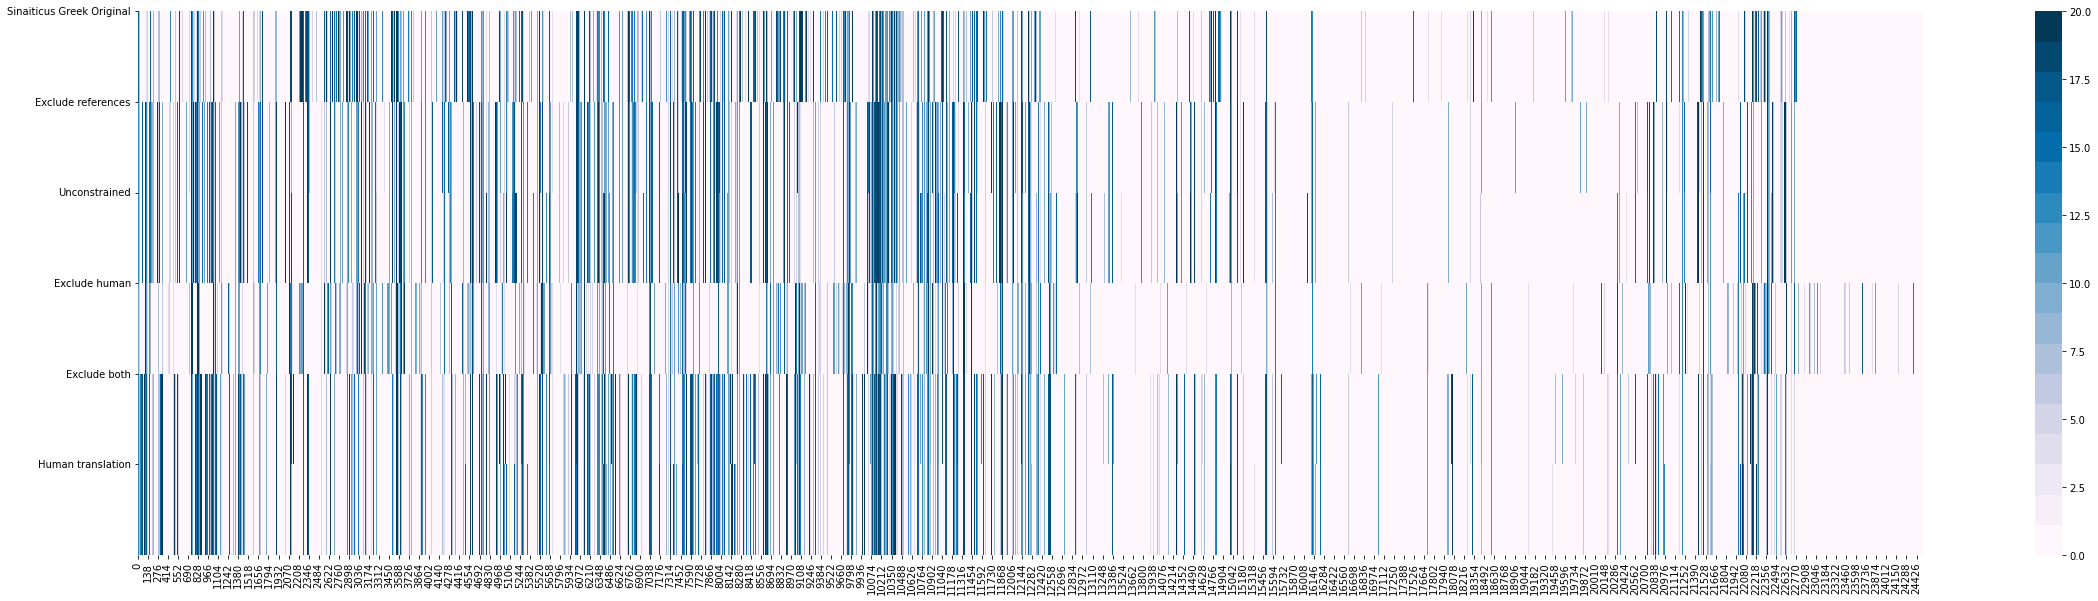

In [8]:
# we want to plot the heatmap, taking in this dataframe
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
def discrete_cmap(N, base_cmap=None):
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


def plot_heatmap(df, name, filters):
    plt.figure(figsize=(40,10))
    df = df.drop('corr', axis=1)
    # make int
    df = df.astype(int)
    # filter out the ones we don't want
    for filter in filters:
        # I want to keep the filter and also 'original'
        df = df[df.index.str.contains(filter) | df.index.str.contains('original')]
    
    N = np.unique(df.values).shape[0]
    print(N)
    sns.heatmap(df, cmap=discrete_cmap(N, 'PuBu'), )
    # ylabels
    plt.yticks(rotation=0, labels=['Sinaiticus Greek Original', 'Exclude references', 'Unconstrained', 'Exclude human', 'Exclude both', 'Human translation'], ticks=[0,1,2,3,4,5])
    # plt.xticks(rotation=90, ticks=range(df.shape[1]), labels=locations)
    # # # plt.savefig(f'{name}_heatmap.png')
    # plt.show()
    # plt.show()

plot_heatmap(old_BC_SG_df_shifted, 'old_BC_SG', filters=['Turkish'])

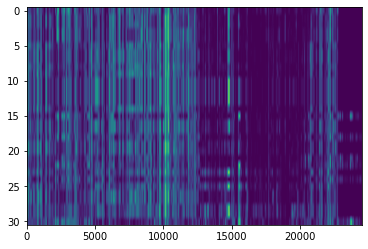

In [32]:
# make the array a dataframe, column are file and lengths
import matplotlib.pyplot as plt

# plt imshow
# make the array all ints
old_BC_SG_shifted = old_BC_SG_df_shifted.astype(int)
plt.imshow(old_BC_SG_shifted, aspect='auto')
# old_BC_SG_df_shifted.head()

18


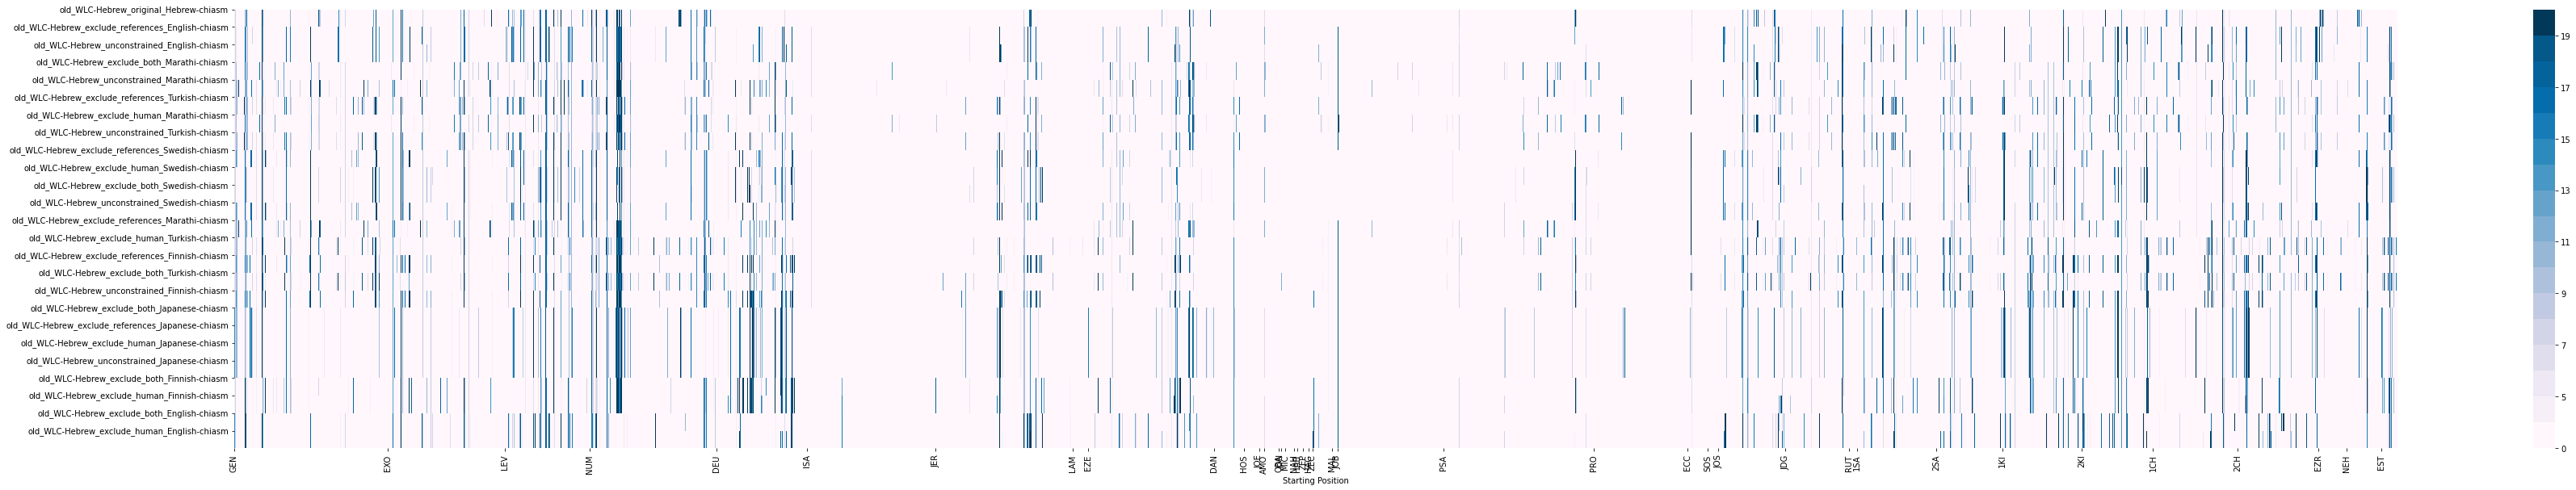

In [207]:
def plot_heatmap(arr, xticks, df_sorted):
    # sns.heatmap(arr, cmap='viridis')
    plt.figure(figsize=(60,10))
    N = np.unique(arr).size
    print(N)
    sns.heatmap(arr, cmap=discrete_cmap(N, 'PuBu'), norm=mpl.colors.BoundaryNorm(np.unique(arr), N))
    # the colorbar should have a tick for each unique value in the array
    # y labels are the df['file'] column
    plt.yticks(range(arr.shape[0]), df_sorted['file'].apply(lambda x: x.split('work_')[1]), rotation=0)
    # use xtick labels xticks.value
    plt.xticks(ticks=xticks.index, labels= xticks.values, rotation=90)
    plt.xlabel('Starting Position')
    # use a discrete color map
    plt.show()


# want to make an array of the df['chiasm_size'] column
# then we can plot that
plot_heatmap(wlc_array, wlc_xticks, wlc_df_sorted)

18


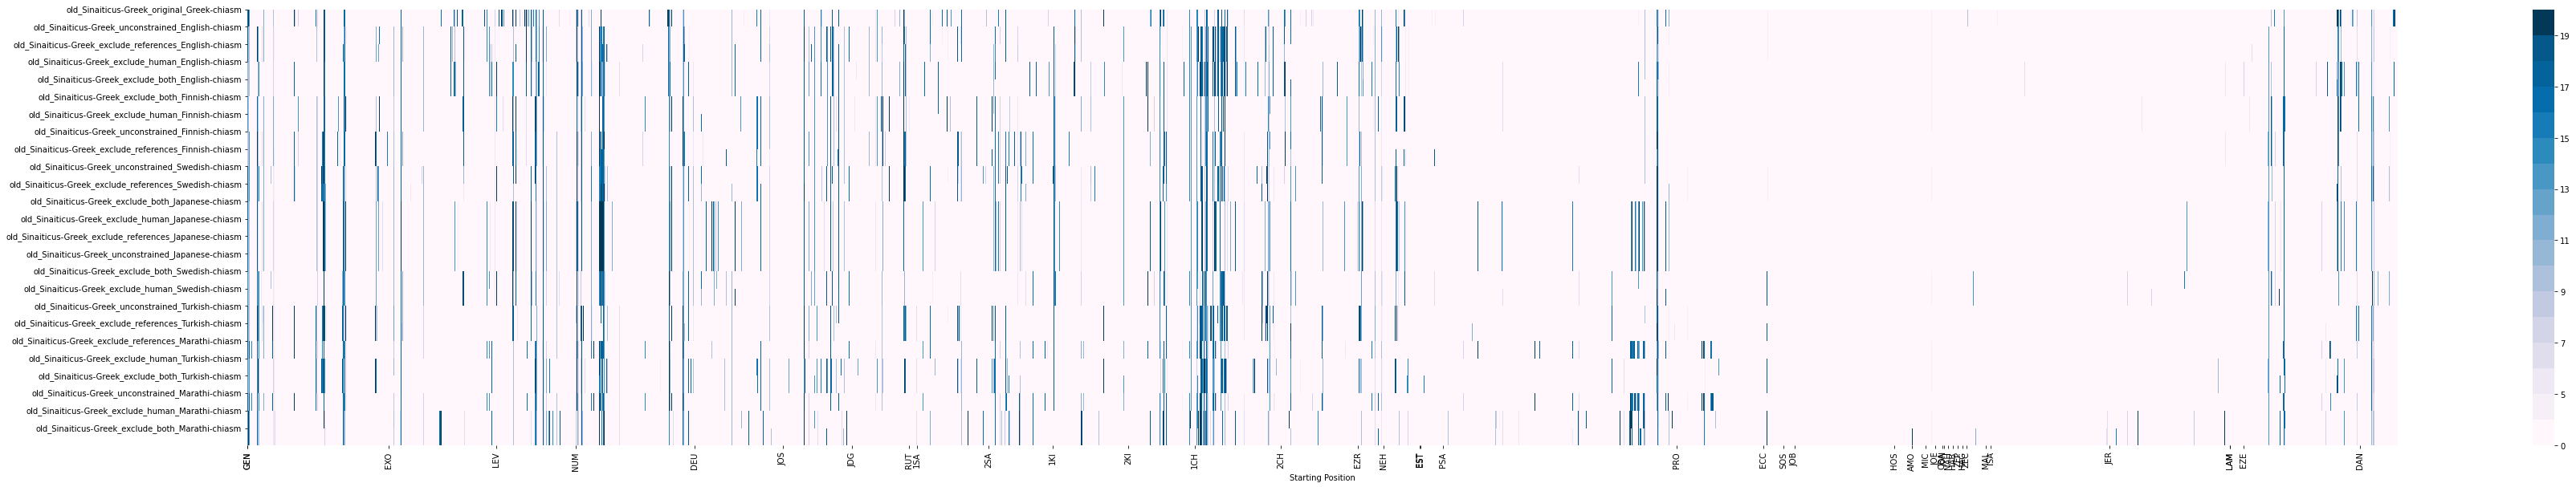

In [208]:
plot_heatmap(old_sinai_array, os_xticks, old_sinai_df_sorted)

18


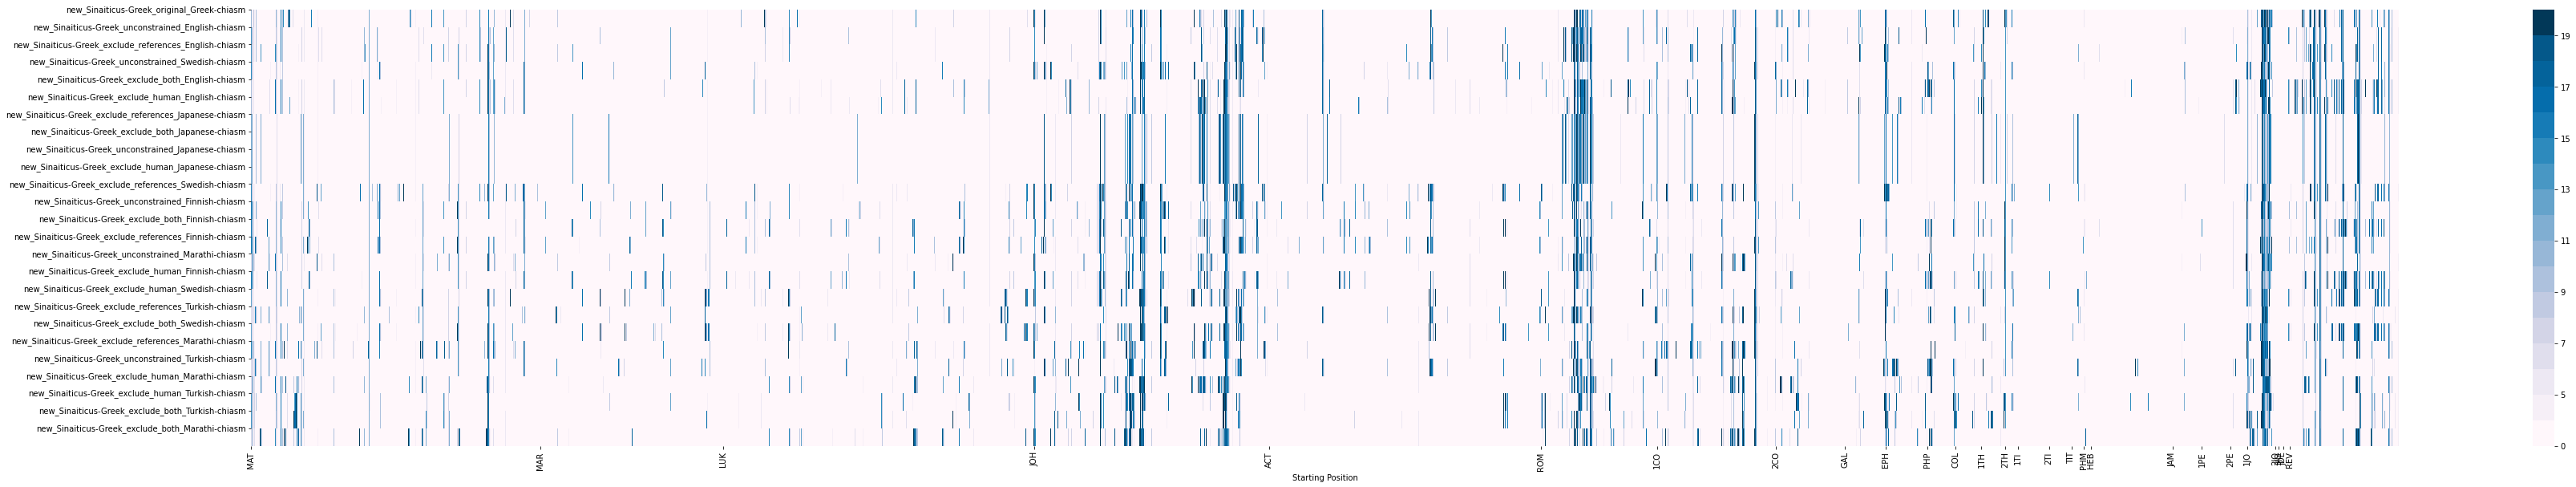

In [209]:
plot_heatmap(new_sinai_array, ns_xticks, new_sinai_df_sorted)

In [211]:
new_sinai_array

array([[10,  7,  6, ...,  0,  0,  0],
       [13,  7,  6, ...,  6,  4,  0],
       [13,  7,  6, ...,  6,  4,  0],
       ...,
       [13,  9, 11, ...,  6,  4,  0],
       [13,  9, 11, ...,  6,  4,  0],
       [ 6,  4, 12, ...,  6,  4,  0]])

In [ ]:
# make an array of just the '

In [ ]:
data = load(original_score_files[0])
data = pd.DataFram(data)

In [54]:
fpath = '/Users/hope/Documents/10 Projects/14 PhD/14.01 GitHub/literary-translation/'

wlc_score_files = glob.glob(os.path.join(fpath, 'chiasm_scores', "**/*WLC-Hebrew*-chiasm.json.gz"), recursive=True)
wlc_translation_files = glob.glob(os.path.join(fpath, 'translations', "**/*WLC-Hebrew*.json.gz"), recursive=True)

bc_score_files = glob.glob(os.path.join(fpath, 'chiasm_scores', "**/*BC*-chiasm.json.gz"), recursive=True)
bc_translation_files = glob.glob(os.path.join(fpath, 'translations', "**/*BC*.json.gz"), recursive=True)

old_sinai_score_files = glob.glob(os.path.join(fpath, 'chiasm_scores', "**/*_old_Sinaiticus-Greek*-chiasm.json.gz"), recursive=True)
old_sinai_translation_files = glob.glob(os.path.join(fpath, 'translations', "**/*_old_Sinaiticus-Greek*.json.gz"), recursive=True)

new_sinai_score_files = glob.glob(os.path.join(fpath, 'chiasm_scores', "**/*_new_Sinaiticus-Greek*-chiasm.json.gz"), recursive=True)
new_sinai_translation_files = glob.glob(os.path.join(fpath, 'translations', "**/*_new_Sinaiticus-Greek*.json.gz"), recursive=True)
# get lengths of each list
len(bc_score_files), len(wlc_score_files), len(old_sinai_score_files), len(new_sinai_score_files), len(bc_translation_files), len(wlc_translation_files), len(old_sinai_translation_files), len(new_sinai_translation_files)

(12, 25, 25, 25, 12, 25, 25, 25)

In [203]:
# taking wlc_score_files as an example, we want to find the file with 'original' in the title
# then take Pearson's correlation between every other file to the original
# then sort the files by the correlation value
# then plot the files in order of the correlation value

# find the original file
orig = [file for file in wlc_score_files if 'original' in file]
# translations = [file for file in wlc_score_files if 'original' not in file]

orig = load(orig[0])
# translations = [load(file) for file in translations]
orig = pd.DataFrame.from_records(orig)
orig['book'] = orig['start'].apply(lambda x: x['book'])
# print(df['book'].values[1499:2000])
orig['chapter'] = orig['start'].apply(lambda x: x['chapter'])
orig['verse'] = orig['start'].apply(lambda x: x['verse'])

# want to find rows where chapter is 1 and verse is 1
book_breaks = orig[(orig['chapter'] == 1) & (orig['verse'] == 1) & (orig['n'] == 4)]
book_breaks
book_breaks['book']


wlc_xticks = book_breaks['book']
wlc_xticks

0        GEN
1500     EXO
2650     LEV
3479     NUM
4722     DEU
5607     ISA
6866     JER
8204     LAM
8358     EZE
9594     DAN
9885     HOS
10032    JOE
10079    AMO
10225    OBA
10246    JON
10283    MIC
10373    NAH
10406    HAB
10462    ZEP
10515    HAG
10553    ZEC
10747    MAL
10796    JOB
11832    PSA
13305    PRO
14220    ECC
14422    SOS
14525    JOS
15183    JDG
15801    RUT
15886    1SA
16658    2SA
17309    1KI
18083    2KI
18780    1CH
19605    2CH
20394    EZR
20674    NEH
21011    EST
Name: book, dtype: object

In [204]:
# find old sinai xticks
orig = [file for file in old_sinai_score_files if 'original' in file]
orig = load(orig[0])
orig = pd.DataFrame.from_records(orig)
orig['book'] = orig['start'].apply(lambda x: x['book'])
orig['chapter'] = orig['start'].apply(lambda x: x['chapter'])
orig['verse'] = orig['start'].apply(lambda x: x['verse'])
book_breaks = orig[(orig['chapter'] == 1) & (orig['verse'] == 1) & (orig['n'] == 4)]
os_xticks = book_breaks['book']

# find new sinai xticks 
orig = [file for file in new_sinai_score_files if 'original' in file]
orig = load(orig[0])
orig = pd.DataFrame.from_records(orig)
orig['book'] = orig['start'].apply(lambda x: x['book'])
orig['chapter'] = orig['start'].apply(lambda x: x['chapter'])
orig['verse'] = orig['start'].apply(lambda x: x['verse'])
book_breaks = orig[(orig['chapter'] == 1) & (orig['verse'] == 1) & (orig['n'] == 4)]
ns_xticks = book_breaks['book']


In [205]:
os_xticks.values

array(['GEN', 'GEN', 'EXO', 'LEV', 'NUM', 'DEU', 'JOS', 'JDG', 'RUT',
       '1SA', '2SA', '1KI', '2KI', '1CH', '2CH', 'EZR', 'NEH', 'EST',
       'EST', 'PSA', 'PRO', 'ECC', 'SOS', 'JOB', 'HOS', 'AMO', 'MIC',
       'JOE', 'OBA', 'JON', 'NAH', 'HAB', 'ZEP', 'HAG', 'ZEC', 'MAL',
       'ISA', 'JER', 'LAM', 'LAM', 'EZE', 'DAN'], dtype=object)

In [206]:
ns_xticks.values

array(['MAT', 'MAR', 'LUK', 'JOH', 'ACT', 'ROM', '1CO', '2CO', 'GAL',
       'EPH', 'PHP', 'COL', '1TH', '2TH', '1TI', '2TI', 'TIT', 'PHM',
       'HEB', 'JAM', '1PE', '2PE', '1JO', '2JO', '3JO', 'JDE', 'REV'],
      dtype=object)

In [121]:
print(df['book_num'].unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


In [101]:
binaries = {}
for fpath in translations:
    # get the file_name
    # work_{testament}_{manuscript}_{condition}_{language}
    # we want file_name = {manuscript}_{condition}_{language}
    # file_name = "_".join(translation.split('/')[-1].split('_')[3:])
    # file_name = file_name.split('-chiasm.')[0]
    # load
    translation = load(fpath)
    # make dataframe
    df = pd.DataFrame.from_records(translation)
    df['book_num'] = df['start'].apply(lambda x: OT_MAP[x["book"]])
    df = df.sort_values(by=['book_num'])
    # get binary
    binary = df.groupby('i').min()['p'] < 0.05
    # get correlation with orig_binary
    corr = pearsonr(orig_binary, binary)[0]
    binaries[fpath] = corr

print(binaries)


{'/Users/hope/Documents/10 Projects/14 PhD/14.01 GitHub/literary-translation/chiasm_scores/work_old_WLC-Hebrew_exclude_human_Japanese-chiasm.json.gz': 0.4859035859786811, '/Users/hope/Documents/10 Projects/14 PhD/14.01 GitHub/literary-translation/chiasm_scores/work_old_WLC-Hebrew_unconstrained_Turkish-chiasm.json.gz': 0.5229696290094216, '/Users/hope/Documents/10 Projects/14 PhD/14.01 GitHub/literary-translation/chiasm_scores/work_old_WLC-Hebrew_exclude_both_Turkish-chiasm.json.gz': 0.4624412266961246, '/Users/hope/Documents/10 Projects/14 PhD/14.01 GitHub/literary-translation/chiasm_scores/work_old_WLC-Hebrew_exclude_references_Finnish-chiasm.json.gz': 0.5238968520983623, '/Users/hope/Documents/10 Projects/14 PhD/14.01 GitHub/literary-translation/chiasm_scores/work_old_WLC-Hebrew_exclude_references_English-chiasm.json.gz': 0.6359070556000321, '/Users/hope/Documents/10 Projects/14 PhD/14.01 GitHub/literary-translation/chiasm_scores/work_old_WLC-Hebrew_exclude_references_Marathi-chiasm.

In [147]:
orig_fpath = [file for file in wlc_score_files if 'original' in file]
binaries[orig_fpath[0]] = 1

In [148]:
binaries
# we want to sort these by the correlation value
sorted_binaries = dict(sorted(binaries.items(), key=lambda item: item[1], reverse=True))
sorted_binaries

{'/Users/hope/Documents/10 Projects/14 PhD/14.01 GitHub/literary-translation/chiasm_scores/work_old_WLC-Hebrew_original_Hebrew-chiasm.json.gz': 1,
 '/Users/hope/Documents/10 Projects/14 PhD/14.01 GitHub/literary-translation/chiasm_scores/work_old_WLC-Hebrew_unconstrained_English-chiasm.json.gz': 0.643590853944511,
 '/Users/hope/Documents/10 Projects/14 PhD/14.01 GitHub/literary-translation/chiasm_scores/work_old_WLC-Hebrew_exclude_references_English-chiasm.json.gz': 0.6359070556000321,
 '/Users/hope/Documents/10 Projects/14 PhD/14.01 GitHub/literary-translation/chiasm_scores/work_old_WLC-Hebrew_unconstrained_Swedish-chiasm.json.gz': 0.5590393292051103,
 '/Users/hope/Documents/10 Projects/14 PhD/14.01 GitHub/literary-translation/chiasm_scores/work_old_WLC-Hebrew_exclude_references_Swedish-chiasm.json.gz': 0.5565985180357277,
 '/Users/hope/Documents/10 Projects/14 PhD/14.01 GitHub/literary-translation/chiasm_scores/work_old_WLC-Hebrew_exclude_human_English-chiasm.json.gz': 0.534795451440

In [95]:
OT_ORDER = ["GEN", "EXO", "LEV", "NUM","DEU",
            "JOS","JDG", 'RUT','1SA','2SA','1KI', '2KI', '1CH', '2CH', 
            'EZR', 'NEH','EST', 'JOB', 'PSA', 'PRO', 'ECC', 'SOS', 
            'ISA', 'JER', 'LAM', 'EZE', 'DAN', 'HOS', 'JOE', 'AMO', 'OBA', 'JON', 'MIC', 'NAH', 'HAB', 'ZEP', 'HAG', 'ZEC', 'MAL']
OT_MAP = {v:k for k,v in enumerate(OT_ORDER)}
OT_MAP

{'GEN': 0,
 'EXO': 1,
 'LEV': 2,
 'NUM': 3,
 'DEU': 4,
 'JOS': 5,
 'JDG': 6,
 'RUT': 7,
 '1SA': 8,
 '2SA': 9,
 '1KI': 10,
 '2KI': 11,
 '1CH': 12,
 '2CH': 13,
 'EZR': 14,
 'NEH': 15,
 'EST': 16,
 'JOB': 17,
 'PSA': 18,
 'PRO': 19,
 'ECC': 20,
 'SOS': 21,
 'ISA': 22,
 'JER': 23,
 'LAM': 24,
 'EZE': 25,
 'DAN': 26,
 'HOS': 27,
 'JOE': 28,
 'AMO': 29,
 'OBA': 30,
 'JON': 31,
 'MIC': 32,
 'NAH': 33,
 'HAB': 34,
 'ZEP': 35,
 'HAG': 36,
 'ZEC': 37,
 'MAL': 38}

In [149]:
def plot_scores(file, ax=None, thres=0.05):
    with gzip.open(file, "rb") as ifd:
        data = [json.loads(line) for line in ifd]
    df = pd.DataFrame.from_records(data)

    # df['book_num'] = df['start'].apply(lambda x: OT_MAP[x["book"]])
    # df = df.sort_values(by=['book_num'])
    # want to sort the df by the book num column
    

    df["color"] = df["p"].apply(lambda x: 1 if x < thres else 0)
    df["color"] *= df["n"]
    # group by i and keep the n with the smallest p-value
    df = df.groupby("i").apply(lambda x: x.loc[x["p"].idxmin()]).reset_index(drop=True)
    
    N = len(df["color"].unique())

    # now we save the plot
    # plt.figure(figsize=(40,5))
    ax.imshow(df["color"].values.reshape(1, -1), cmap=discrete_cmap(N, 'PuBu'), aspect="auto", norm=mpl.colors.BoundaryNorm(sorted(df['color'].unique()), N))
    # want the ticks of the colorbar to be the n values
    # plt.colorbar(ticks=sorted(df['color'].unique()))
    # plt.axis("off")

    # the path of the file looks like this "work/${TESTAMENT}/${MANUSCRIPT}/${CONDITION_NAME}/${LANGUAGE}-chiasm.json.gz"
    # id = "_".join(file.split("/")[1:])
    # plt.title(id.replace('-chiasm.json.gz', '')+ f' p={thres}')
    # plt.savefig(os.path.join(OUTPUT, id.replace("-chiasm.json.gz", ".png")), bbox_inches='tight')
    # plt.close()

# plot_scores(orig_fpath[0])

In [84]:
# test splot_scores on the first file in sorted_binaries
plot_scores(list(sorted_binaries.keys())[0])

TypeError: plot_scores() missing 1 required positional argument: 'ax'

In [55]:
[0] + list(range(4,21))

[0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

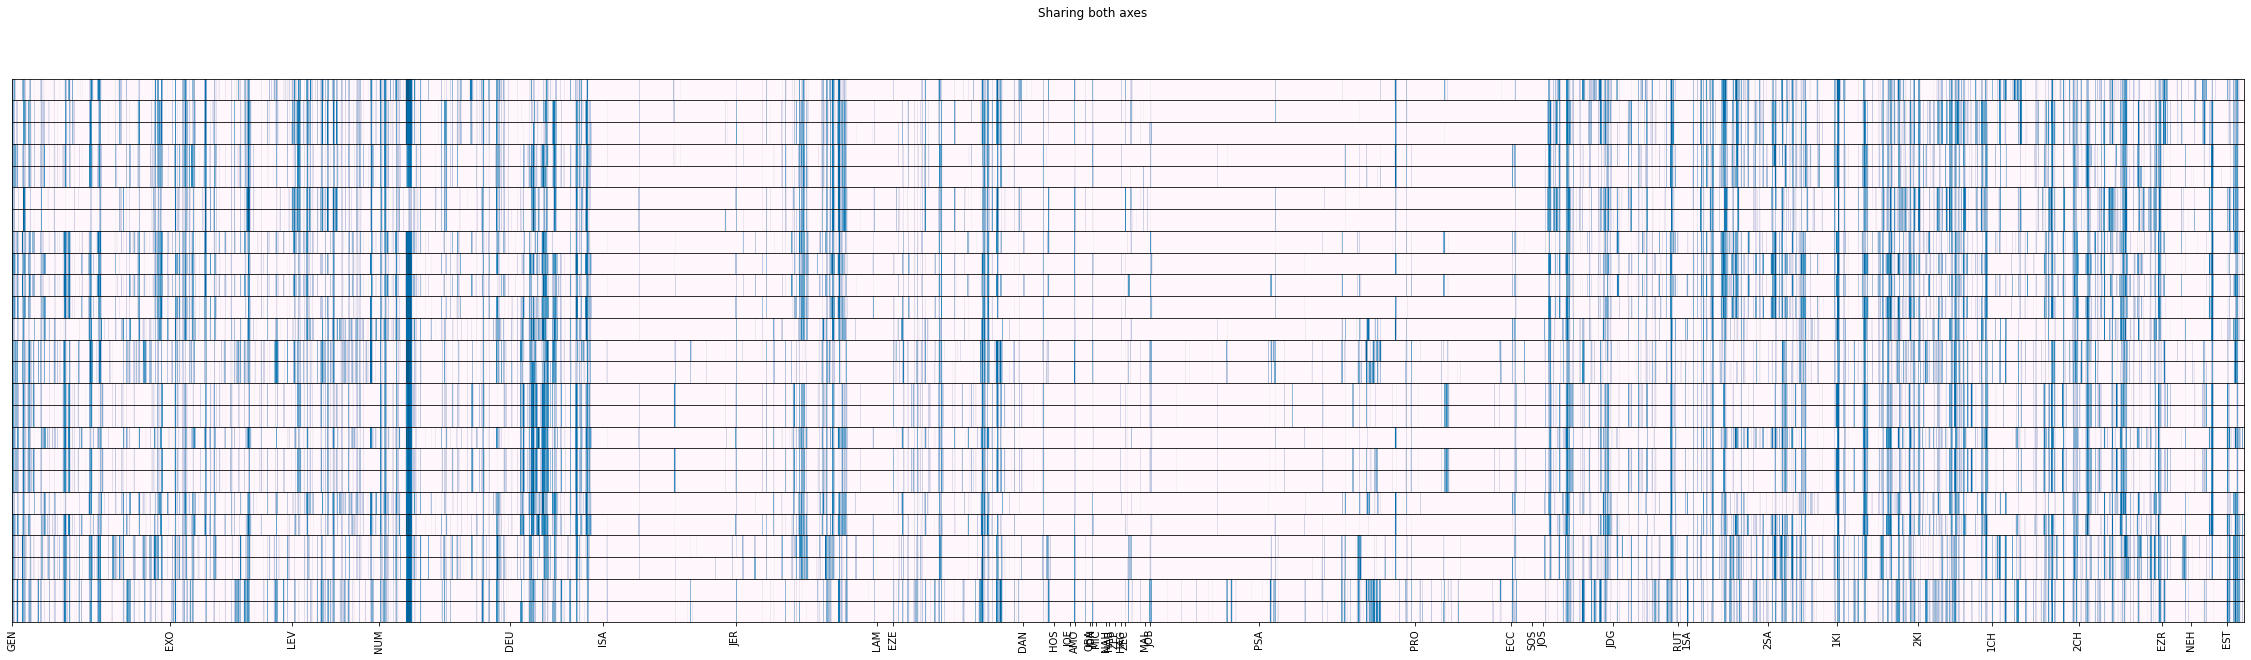

In [166]:
# code snippet to plot all the files in sorted_binaries in order
fig = plt.figure(figsize=(40,10))
gs = fig.add_gridspec(len(sorted_binaries.keys()), hspace=0)
axs = gs.subplots(sharex=True, sharey=True)


fig.suptitle('Sharing both axes')
# fig.colorbar(ticks=[0] + list(range(4,21)))
# fig.axis("off")

for i, (ax, file) in enumerate(zip(axs, sorted_binaries.keys())):
    plot_scores(file, ax)
    ax.set_xticks(ticks=xticks.index, labels=xticks.values)
    # ax.set_xticklabels(xticks.values, rotation=45, ha='right')
    # for tick in ax.get_xticklabels():
    #     tick.set_rotation(45)
    # ax.label_outer()
    # remove y axis as well
    ax.get_yaxis().set_visible(False)
    
    # add a colorbar
    # fig.colorbar(ax, ticks=[0] + list(range(4,21)))

for ax in axs:
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

# save fig

# fig.align_xlabels(axs)
# axs[].set_xticks(ticks=xticks.index, labels=xticks.values, rotation="vertical")
# rotate the xlabels 90 degrees
# axs[0].xticks(rotation=90)
# want to map certain x values to string names
# axs[0].set_xticks([0, 1, 2, 3]) 
# axs[0].plot(x, y ** 2)
# axs[1].plot(x, 0.3 * y, 'o')
# axs[2].plot(x, y, '+')

# Hide x labels and tick labels for all but bottom plot.
# for ax in axs:
#     ax.label_outer()

In [170]:
fig.savefig('wlc_ordered.pdf', bbox_inches="tight")

In [101]:
# want to make a mapping  of the i column to the book. Want to find the i positions where the start column is chapter 1 and verse 1
# just take the original one
print(df.head(10))




Empty DataFrame
Columns: [file, chiasm_size]
Index: []


KeyError: 'start'

In [151]:
xticks.index, xticks.values

(Int64Index([    0,  1500,  2650,  3479,  4722,  5607,  6866,  8204,  8358,
              9594,  9885, 10032, 10079, 10225, 10246, 10283, 10373, 10406,
             10462, 10515, 10553, 10747, 10796, 11832, 13305, 14220, 14422,
             14525, 15183, 15801, 15886, 16658, 17309, 18083, 18780, 19605,
             20394, 20674, 21011],
            dtype='int64'),
 array(['GEN', 'EXO', 'LEV', 'NUM', 'DEU', 'ISA', 'JER', 'LAM', 'EZE',
        'DAN', 'HOS', 'JOE', 'AMO', 'OBA', 'JON', 'MIC', 'NAH', 'HAB',
        'ZEP', 'HAG', 'ZEC', 'MAL', 'JOB', 'PSA', 'PRO', 'ECC', 'SOS',
        'JOS', 'JDG', 'RUT', '1SA', '2SA', '1KI', '2KI', '1CH', '2CH',
        'EZR', 'NEH', 'EST'], dtype=object))

In [10]:


data = load(score_files[0])
df = pd.DataFrame.from_records(data)
df.head()

,n,i,p,start,end
0,4,0,0.421578,"{'book': 'MAT', 'chapter': 1, 'verse': 1}","{'book': 'MAT', 'chapter': 1, 'verse': 4}"
1,4,1,0.141858,"{'book': 'MAT', 'chapter': 1, 'verse': 2}","{'book': 'MAT', 'chapter': 1, 'verse': 5}"
2,4,2,0.016983,"{'book': 'MAT', 'chapter': 1, 'verse': 3}","{'book': 'MAT', 'chapter': 1, 'verse': 6}"
3,4,3,0.011988,"{'book': 'MAT', 'chapter': 1, 'verse': 4}","{'book': 'MAT', 'chapter': 1, 'verse': 7}"
4,4,4,0.001998,"{'book': 'MAT', 'chapter': 1, 'verse': 5}","{'book': 'MAT', 'chapter': 1, 'verse': 8}"


In [17]:
# group by i and take the minimun p-value
# df.groupby('i').min()
# if the p-value is less than a threshold, True
binary = df.groupby('i').min()['p'] < 0.05
binary[50:70]

i
50    False
51    False
52    False
53    False
54    False
55    False
56    False
57    False
58    False
59    False
60    False
61    False
62    False
63     True
64    False
65    False
66    False
67    False
68     True
69     True
Name: p, dtype: bool